In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import catboost
import xgboost
import optuna
import pickle

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

warnings.filterwarnings("ignore")

In [81]:
data = pd.read_csv(r'D:\python\1_Internship\naimi_new4_preprocessed.csv')
data.describe()

,id,ltd,ltm,total_replenishment_lt,total_replenishment_pd,cash_expenditure_pd,services_count_pd,amount,duration,npl_days,current_installments_sum,age_pd,current_debt_lt,nps_lt,support_requests_pd,recency_segment_lt,monetary_segment_lt,frequency_segment_lt,avg_check_reviews_lt,avg_daily_reviews_lt,avg_amount_reviews_lt,rating_reviews_lt,avg_check_categories_pd,avg_check_reviews_pd,responses_per_day_pd,connects_per_day_pd,calls_per_day_pd,hires_per_day_pd,review_requests_per_day_pd,reviews_per_day_pd,daily_amount_responses_pd,daily_amount_connects_pd,daily_amount_calls_pd,daily_amount_hires_pd,daily_amount_review_requests_pd,daily_amount_reviews_pd,rating_reviews_pd,avg_responses_requests_cpd,avg_responses_responder_cpd,avg_requests_responder_cpd,daily_amount_requests_responder_cpd,daily_amount_requests_connects_cpd,paid_period_proportion_pd,responder_period_proportion_pd,connect_period_proportion_pd,catalog_responses_proportion_pd,target,Cluster,year,month,day,year_opened,month_opened,day_opened
count,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000
mean,252531.0241,720.0084,24.4869,125604.9613,57816.1154,57668.4758,7.5633,2353.5049,14.9152,42.4100,0.0000,35.1526,49739.2229,2.4403,11.9956,4.5495,2.3083,3.1221,27231.5712,0.0723,1247.3653,4.9027,28097.7032,19915.9470,4.0254,1.8228,1.7977,0.1098,0.1098,0.1178,81822.4128,36233.0793,36523.0412,1579.8219,1440.7213,1791.8289,3.7789,6.0038,0.3255,0.0583,1866.0236,2538.2097,53.3120,46.3283,39.1408,0.1872,0.2393,1.8243,2021.8555,6.4654,15.7167,2019.9017,6.2408,16.1035
std,204687.4280,492.1116,16.4085,232241.3137,181297.0235,181629.8380,6.6226,3277.1073,8.5503,95.5468,0.0000,7.8320,133905.6440,4.2143,27.2312,1.0688,0.9533,1.2273,30758.6102,0.1026,1515.3542,0.5048,22527.4851,31931.1252,4.9425,2.7532,2.6536,0.2369,0.2508,0.2168,125117.4404,57763.3298,61733.7983,2699.4868,2792.4542,2607.9005,2.1194,2.4545,0.1321,0.0268,1909.0321,2403.2924,31.3081,29.0870,28.3281,0.2293,0.4267,1.1507,0.7819,3.8075,8.7796,1.3367,3.5138,8.6964
min,794.0000,3.0000,1.0000,0.0000,0.0000,0.0000,0.0000,50.0000,10.0000,0.0000,0.0000,18.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4000.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2021.0000,1.0000,1.0000,2016.0000,1.0000,1.0000
25%,93389.0000,337.0000,12.0000,11098.7500,2500.0000,2350.0000,3.0000,750.0000,10.0000,0.0000,0.0000,29.0000,0.0000,0.0000,0.0000,5.0000,2.0000,2.0000,10870.1112,0.0140,314.2053,5.0000,13400.0000,7060.1429,0.7333,0.2889,0.2778,0.0000,0.0000,0.0111,15455.1389,5934.1667,5568.3333,0.0000,0.0000,108.3333,4.0000,4.0947,0.2358,0.0402,707.9439,1058.0660,25.0000,22.2222,15.5556,0.0238,0.0000,1.0000,2021.0000,3.0000,8.0000,2019.0000,3.0000,9.0000
50%,178620.0000,649.0000,22.0000,34000.0000,8000.0000,7560.0000,5.0000,1250.0000,10.0000,8.0000,0.0000,34.0000,10572.7750,0.0000,1.0000,5.0000,2.0000,3.0000,14835.9063,0.0364,800.6373,5.0000,19062.5000,11550.0000,2.1000,0.8112,0.8222,0.0222,0.0111,0.0333,47674.5000,19071.9444,18512.5000,468.7500,222.2222,719.4444,5.0000,5.7141,0.3444,0.0536,1103.3671,1621.3212,55.0000,44.4444,34.4444,0.0906,0.0000,2.0000,2022.0000,7.0000,16.0000,2020.0000,6.0000,16.0000
75%,353628.0000,984.2500,33.0000,120611.2500,24500.0000,23947.7500,11.0000,2730.0000,15.0000,29.0000,0.0000,41.0000,41217.6250,4.0000,8.0000,5.0000,2.0000,4.0000,366

In [6]:
data.head(5)

,id,ltd,ltm,data_collection_date,work_start_date,total_replenishment_lt,total_replenishment_pd,cash_expenditure_pd,services_count_pd,phone_number,amount,duration,installment_status,npl_days,current_installments_sum,age_pd,gender_lt,base_city_pd,os_lt,current_debt_lt,nps_lt,selected_service_categories_lt,support_requests_pd,recency_segment_lt,monetary_segment_lt,frequency_segment_lt,avg_check_reviews_lt,avg_daily_reviews_lt,avg_amount_reviews_lt,rating_reviews_lt,avg_check_categories_pd,avg_check_reviews_pd,responses_per_day_pd,connects_per_day_pd,calls_per_day_pd,hires_per_day_pd,review_requests_per_day_pd,reviews_per_day_pd,daily_amount_responses_pd,daily_amount_connects_pd,daily_amount_calls_pd,daily_amount_hires_pd,daily_amount_review_requests_pd,daily_amount_reviews_pd,rating_reviews_pd,avg_responses_requests_cpd,avg_responses_responder_cpd,avg_requests_responder_cpd,daily_amount_requests_responder_cpd,daily_amount_requests_connects_cpd,paid_period_proportion_pd,responder_period_proportion_pd,connect_period_proportion_pd,catalog_responses_proportion_pd,target,Cluster,year,month,day,season,year_opened,month_opened,day_opened,season_opened
0,678898,719,24,2023-11-06,2021-11-17 16:59:40,37445.0000,15060.0000,10400.0000,5,+77072509797,13200.0000,10,Выплачен,1,0.0000,26,Муж,Алматы,Android,0.0000,10,"Работы с потолками, Работы по кровле и крыше, ...",3,5,2,2,66250.0000,0.0028,184.2837,5.0000,44140.0000,0.0000,0.6778,0.3333,0.3000,0.0111,0.0000,0.0000,32002.2222,15038.8889,13986.1111,500.0000,0.0000,0.0000,0.0000,4.2968,0.2315,0.0539,1890.6794,2232.5394,26,17.7778,16.6667,0.0000,0,2,2023,11,6,Autumn,2021,11,17,Autumn
1,180301,1121,38,2023-11-03,2020-10-08 21:48:47,133000.0000,16500.0000,15760.0000,5,+77789286102,4200.0000,10,Выплачен,0,0.0000,37,Муж,Астана,Android,0.0000,0,"Услуги сварщиков, Работы по отоплению, Услуги ...",0,5,2,5,12876.6364,0.0393,505.4166,5.0000,57600.0000,21666.6667,2.1000,0.8333,0.8111,0.0222,0.0000,0.0333,38875.0000,17862.7778,17541.1111,444.4444,0.0000,722.2222,5.0000,4.4523,0.3388,0.0761,4423.1296,5363.3584,68,54.4444,38.8889,0.0265,0,2,2023,11,3,Autumn,2020,10,8,Autumn
2,130936,1462,49,2023-11-02,2019-11-01 11:17:33,6450.0000,0.0000,0.0000,12,+77757017009,9600.0000,10,Просроченный,9,0.0000,32,Муж,Алматы,Android,0.0000,0,"Другие строительно-монтажные работы, Услуги ги...",0,2,2,2,24250.0000,0.0007,16.5869,5.0000,42308.3333,0.0000,0.1778,0.1111,0.0667,0.0000,0.0000,0.0000,9953.8889,7908.3333,5508.3333,0.0000,0.0000,0.0000,0.0000,4.6921,0.5114,0.1090,4461.1848,5061.3046,1,1.1111,1.1111,0.0000,0,3,2023,11,2,Autumn,2019,11,1,Autumn
3,958601,212,8,2023-11-01,2023-04-03 09:38:29,51960.0000,17645.0000,17700.0000,15,+77785705495,3920.0000,10,Выплачен,0,0.0000,48,Муж,Астана,Android,0.0000,0,"Работы с потолками, Услуги гипсокартонщиков, Д...",2,5,2,5,45000.0000,0.0047,212.2642,5.0000,53996.6667,0.0000,1.4333,1.1000,1.2556,0.0111,0.0111,0.0000,116828.6667,80411.1111,92813.3333,555.5556,527.7778,0.0000,0.0000,3.8890,0.4259,0.1095,6507.5016,7386.3792,58,60.0000,53.3333,0.1705,0,3,2023,11,1,Autumn,2023,4,3,Spring
4,568773,772,26,2023-11-01,2021-09-20 14:07:23,384900.0000,63300.0000,61325.0000,17,+77771776367,50400.0000,10,Выплачен,0,0.0000,29,Муж,Алматы,Android,0.0000,10,"Работы с потолками, Услуги гипсокартонщиков, У...",5,5,4,5,14024.6853,0.1852,2597.8368,4.7902,16100.0000,14000.0000,8.3000,4.5444,5.7778,0.2556,0.0000,0.1556,106720.0000,61002.2222,78751.1111,4680.0000,0.0000,2177.7778,4.4286,5.0296,0.5760,0.1145,1880.9111,2157.9332,96,83.3333,76.6667,0.0054,0,1,2023,11,1,Autumn,2021,9,20,Autumn


In [7]:
data.shape

(22056, 64)

In [8]:
columns_to_drop = ['data_collection_date',
 'work_start_date',
 'phone_number',
 'installment_status',
 'current_installments_sum',
 'nps_lt',
 'selected_service_categories_lt',
 'monetary_segment_lt',
 'Cluster']

data = data.drop(columns_to_drop,axis=1)

In [9]:
data = data.drop_duplicates()
print(data.shape)
data.describe()

(22056, 55)


,id,ltd,ltm,total_replenishment_lt,total_replenishment_pd,cash_expenditure_pd,services_count_pd,amount,duration,npl_days,age_pd,current_debt_lt,support_requests_pd,recency_segment_lt,frequency_segment_lt,avg_check_reviews_lt,avg_daily_reviews_lt,avg_amount_reviews_lt,rating_reviews_lt,avg_check_categories_pd,avg_check_reviews_pd,responses_per_day_pd,connects_per_day_pd,calls_per_day_pd,hires_per_day_pd,review_requests_per_day_pd,reviews_per_day_pd,daily_amount_responses_pd,daily_amount_connects_pd,daily_amount_calls_pd,daily_amount_hires_pd,daily_amount_review_requests_pd,daily_amount_reviews_pd,rating_reviews_pd,avg_responses_requests_cpd,avg_responses_responder_cpd,avg_requests_responder_cpd,daily_amount_requests_responder_cpd,daily_amount_requests_connects_cpd,paid_period_proportion_pd,responder_period_proportion_pd,connect_period_proportion_pd,catalog_responses_proportion_pd,target,year,month,day,year_opened,month_opened,day_opened
count,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000,22056.0000
mean,252531.0241,720.0084,24.4869,125604.9613,57816.1154,57668.4758,7.5633,2353.5049,14.9152,42.4100,35.1526,49739.2229,11.9956,4.5495,3.1221,27231.5712,0.0723,1247.3653,4.9027,28097.7032,19915.9470,4.0254,1.8228,1.7977,0.1098,0.1098,0.1178,81822.4128,36233.0793,36523.0412,1579.8219,1440.7213,1791.8289,3.7789,6.0038,0.3255,0.0583,1866.0236,2538.2097,53.3120,46.3283,39.1408,0.1872,0.2393,2021.8555,6.4654,15.7167,2019.9017,6.2408,16.1035
std,204687.4280,492.1116,16.4085,232241.3137,181297.0235,181629.8380,6.6226,3277.1073,8.5503,95.5468,7.8320,133905.6440,27.2312,1.0688,1.2273,30758.6102,0.1026,1515.3542,0.5048,22527.4851,31931.1252,4.9425,2.7532,2.6536,0.2369,0.2508,0.2168,125117.4404,57763.3298,61733.7983,2699.4868,2792.4542,2607.9005,2.1194,2.4545,0.1321,0.0268,1909.0321,2403.2924,31.3081,29.0870,28.3281,0.2293,0.4267,0.7819,3.8075,8.7796,1.3367,3.5138,8.6964
min,794.0000,3.0000,1.0000,0.0000,0.0000,0.0000,0.0000,50.0000,10.0000,0.0000,18.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4000.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2021.0000,1.0000,1.0000,2016.0000,1.0000,1.0000
25%,93389.0000,337.0000,12.0000,11098.7500,2500.0000,2350.0000,3.0000,750.0000,10.0000,0.0000,29.0000,0.0000,0.0000,5.0000,2.0000,10870.1112,0.0140,314.2053,5.0000,13400.0000,7060.1429,0.7333,0.2889,0.2778,0.0000,0.0000,0.0111,15455.1389,5934.1667,5568.3333,0.0000,0.0000,108.3333,4.0000,4.0947,0.2358,0.0402,707.9439,1058.0660,25.0000,22.2222,15.5556,0.0238,0.0000,2021.0000,3.0000,8.0000,2019.0000,3.0000,9.0000
50%,178620.0000,649.0000,22.0000,34000.0000,8000.0000,7560.0000,5.0000,1250.0000,10.0000,8.0000,34.0000,10572.7750,1.0000,5.0000,3.0000,14835.9063,0.0364,800.6373,5.0000,19062.5000,11550.0000,2.1000,0.8112,0.8222,0.0222,0.0111,0.0333,47674.5000,19071.9444,18512.5000,468.7500,222.2222,719.4444,5.0000,5.7141,0.3444,0.0536,1103.3671,1621.3212,55.0000,44.4444,34.4444,0.0906,0.0000,2022.0000,7.0000,16.0000,2020.0000,6.0000,16.0000
75%,353628.0000,984.2500,33.0000,120611.2500,24500.0000,23947.7500,11.0000,2730.0000,15.0000,29.0000,41.0000,41217.6250,8.0000,5.0000,4.0000,36650.4836,0.0931,1644.8036,5.0000,36125.0000,20000.0000,5.1000,1.9667,1.9667,0.0778,0.0778,0.1011,111405.8333,46872.9167,47982.2500,1666.6667,1444.4444,2291.6667,5.0000,7.4082,0.4197,0.0736,2306.7851,3141.8462,81.0000,68.8889,58.8889,0.2676,0.0000,2022.0000,10.0000,2

In [10]:
data = data[['total_replenishment_lt',
 'total_replenishment_pd',
 'current_debt_lt',
 'hires_per_day_pd',
 'cash_expenditure_pd',
 'daily_amount_calls_pd',
 'support_requests_pd',
 'catalog_responses_proportion_pd',
 'amount','duration',
 'paid_period_proportion_pd',
 'avg_check_reviews_lt',
 'avg_responses_responder_cpd',
 'avg_daily_reviews_lt',
 'avg_check_reviews_pd',
 'avg_responses_requests_cpd',
 'daily_amount_requests_connects_cpd',
 'daily_amount_reviews_pd',
 'daily_amount_hires_pd',
 'age_pd',
 'avg_amount_reviews_lt',
 'avg_check_categories_pd',
 'frequency_segment_lt',
 'calls_per_day_pd',
 'recency_segment_lt',
 'target']]

In [11]:
data = data.drop_duplicates()
data.columns

Index(['total_replenishment_lt', 'total_replenishment_pd', 'current_debt_lt', 'hires_per_day_pd', 'cash_expenditure_pd', 'daily_amount_calls_pd', 'support_requests_pd', 'catalog_responses_proportion_pd', 'amount', 'duration', 'paid_period_proportion_pd', 'avg_check_reviews_lt', 'avg_responses_responder_cpd', 'avg_daily_reviews_lt', 'avg_check_reviews_pd', 'avg_responses_requests_cpd', 'daily_amount_requests_connects_cpd', 'daily_amount_reviews_pd', 'daily_amount_hires_pd', 'age_pd', 'avg_amount_reviews_lt', 'avg_check_categories_pd', 'frequency_segment_lt', 'calls_per_day_pd', 'recency_segment_lt', 'target'], dtype='object')

In [12]:
X = data.drop(['target'],axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.25, random_state=42)

print(X_train.shape)
y.value_counts()

(16497, 25)


target
0    16728
1     5268
Name: count, dtype: int64

In [13]:
y_train.value_counts(normalize=True)

target
0   0.7596
1   0.2404
Name: proportion, dtype: float64

In [14]:
y_test.value_counts(normalize=True)

target
0   0.7632
1   0.2368
Name: proportion, dtype: float64

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21996 entries, 0 to 22055
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   total_replenishment_lt              21996 non-null  float64
 1   total_replenishment_pd              21996 non-null  float64
 2   current_debt_lt                     21996 non-null  float64
 3   hires_per_day_pd                    21996 non-null  float64
 4   cash_expenditure_pd                 21996 non-null  float64
 5   daily_amount_calls_pd               21996 non-null  float64
 6   support_requests_pd                 21996 non-null  int64  
 7   catalog_responses_proportion_pd     21996 non-null  float64
 8   amount                              21996 non-null  float64
 9   duration                            21996 non-null  int64  
 10  paid_period_proportion_pd           21996 non-null  int64  
 11  avg_check_reviews_lt                21996 non-

In [84]:
# Функция для удаления аутлайеров
def remove_outliers_qr(X, y, threshold=3):
    X_scaled = (X - X.mean()) / X.std()
    
    Q, R = np.linalg.qr(X_scaled.T)
    mahalanobis_dist = np.sqrt(np.sum(R**2, axis=0))
    
    outlier_mask = mahalanobis_dist < threshold
    X_cleaned = X.loc[outlier_mask]
    y_cleaned = y.loc[outlier_mask]
    
    return X_cleaned, y_cleaned

X_cleaned, y_cleaned = remove_outliers_qr(X, y)

X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X_cleaned, y_cleaned, test_size=0.25, random_state=42)

In [66]:
with open(r'D:\python\1_Internship\cbc_final_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(model)

In [80]:
def evaluate_model1(model, model_name, X_train, X_test, y_train, y_test):    
    test_probabilities = model.predict_proba(X_test)[:, 1]

label_encoder = LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:
    data[col] = label_encoder.fit_transform(data[col])

X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.25, random_state=42)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

def threshold_breakdown(train_set, test_set, target='target', prediction='model1_prediction'):
    model_threshold_list = []

    for thres in [x / 100 for x in range(30, 70, 5)]:
        thres_metrics = dict()

        train_set['prediction_label'] = (train_set[prediction] > thres).astype(int)
        test_set['prediction_label'] = (test_set[prediction] > thres).astype(int)

        tn_train, fp_train, fn_train, tp_train = confusion_matrix(train_set[target], train_set['prediction_label']).ravel()
        tn_test, fp_test, fn_test, tp_test = confusion_matrix(test_set[target], test_set['prediction_label']).ravel()
        thres_metrics['Threshold'] = int(thres * 100)
        thres_metrics['AUC Train'] = round(roc_auc_score(train_set[target], train_set[prediction]), 2)
        thres_metrics['AUC Blind'] = round(roc_auc_score(test_set[target], test_set[prediction]), 2)
        thres_metrics['Accuracy Train'] = accuracy_score(train_set[target], train_set['prediction_label'])
        thres_metrics['Accuracy Blind'] = accuracy_score(test_set[target], test_set['prediction_label']) 
        thres_metrics['Approval Train rate'] = round((fn_train + tn_train) / (tn_train + fp_train + fn_train + tp_train), 4)
        thres_metrics['Approval Blind rate'] = round((fn_test + tn_test) / (tn_test + fp_test + fn_test + tp_test), 4) 
        thres_metrics['Good found Train'] = round(tn_train / (fp_train + tn_train), 4)
        thres_metrics['Good found Blind'] = round(tn_test / (fp_test + tn_test), 4)  
        thres_metrics['Bad found Train'] = round(tp_train / (fn_train + tp_train), 4)
        thres_metrics['Bad found Blind'] = round(tp_test / (fn_test + tp_test), 4) 

        model_threshold_list.append(thres_metrics)
    
    return pd.DataFrame(model_threshold_list)

pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

threshold_df = threshold_breakdown(
    train_set=pd.DataFrame({'target': y_train, 'model1_prediction': model.predict_proba(X_train)[:,1]}),
    test_set=pd.DataFrame({'target': y_test, 'model1_prediction': y_pred_proba[:,1]})
)

threshold_df

,Threshold,AUC Train,AUC Blind,Accuracy Train,Accuracy Blind,Approval Train rate,Approval Blind rate,Good found Train,Good found Blind,Bad found Train,Bad found Blind
0,30,0.8000,0.7900,0.7298,0.7252,0.6387,0.6452,0.7426,0.7427,0.6896,0.6690
1,35,0.8000,0.7900,0.7641,0.7540,0.7393,0.7452,0.8314,0.8270,0.5514,0.5184
2,40,0.8000,0.7900,0.7818,0.7769,0.8272,0.8314,0.9009,0.8985,0.4057,0.3848
3,45,0.8000,0.7900,0.7869,0.7905,0.8986,0.8960,0.9512,0.9497,0.2675,0.2773
4,50,0.8000,0.7900,0.7818,0.7847,0.9474,0.9502,0.9800,0.9814,0.1556,0.1505
5,55,0.8000,0.7900,0.7726,0.7774,0.9778,0.9778,0.9939,0.9948,0.0731,0.0768
6,60,0.8000,0.7900,0.7650,0.7712,0.9922,0.9895,0.9985,0.9983,0.0275,0.0392
7,65,0.8000,0.7900,0.7627,0.7689,0.9967,0.9940,0.9999,0.9998,0.0134,0.0246


In [68]:
evaluate_model1(model, "Catboost", X_train, X_test,y_train, y_test)

In [69]:
model.get_feature_importance(prettified=True).head(30)

,Feature Id,Importances
0,total_replenishment_pd,17.8490
1,total_replenishment_lt,12.4111
2,avg_daily_reviews_lt,6.5765
3,amount,6.2330
4,current_debt_lt,5.4982
5,daily_amount_hires_pd,3.8668
6,avg_check_reviews_lt,3.6113
7,catalog_responses_proportion_pd,3.4733
8,support_requests_pd,3.4727
9,paid_period_proportion_pd,3.4483


Text(0.5, 1.0, 'Top 10 Feature Importances with CatBoostClassifier')

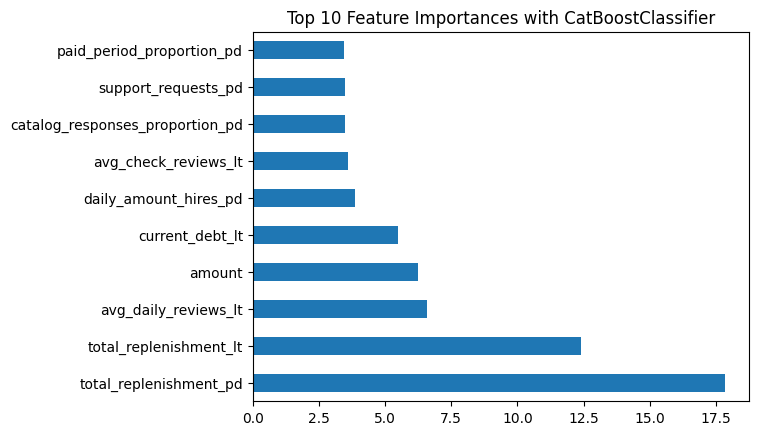

In [70]:
(pd.Series(model.feature_importances_, index=X_train.columns).nlargest(10).plot(kind='barh'))
plt.title('Top 10 Feature Importances with CatBoostClassifier')

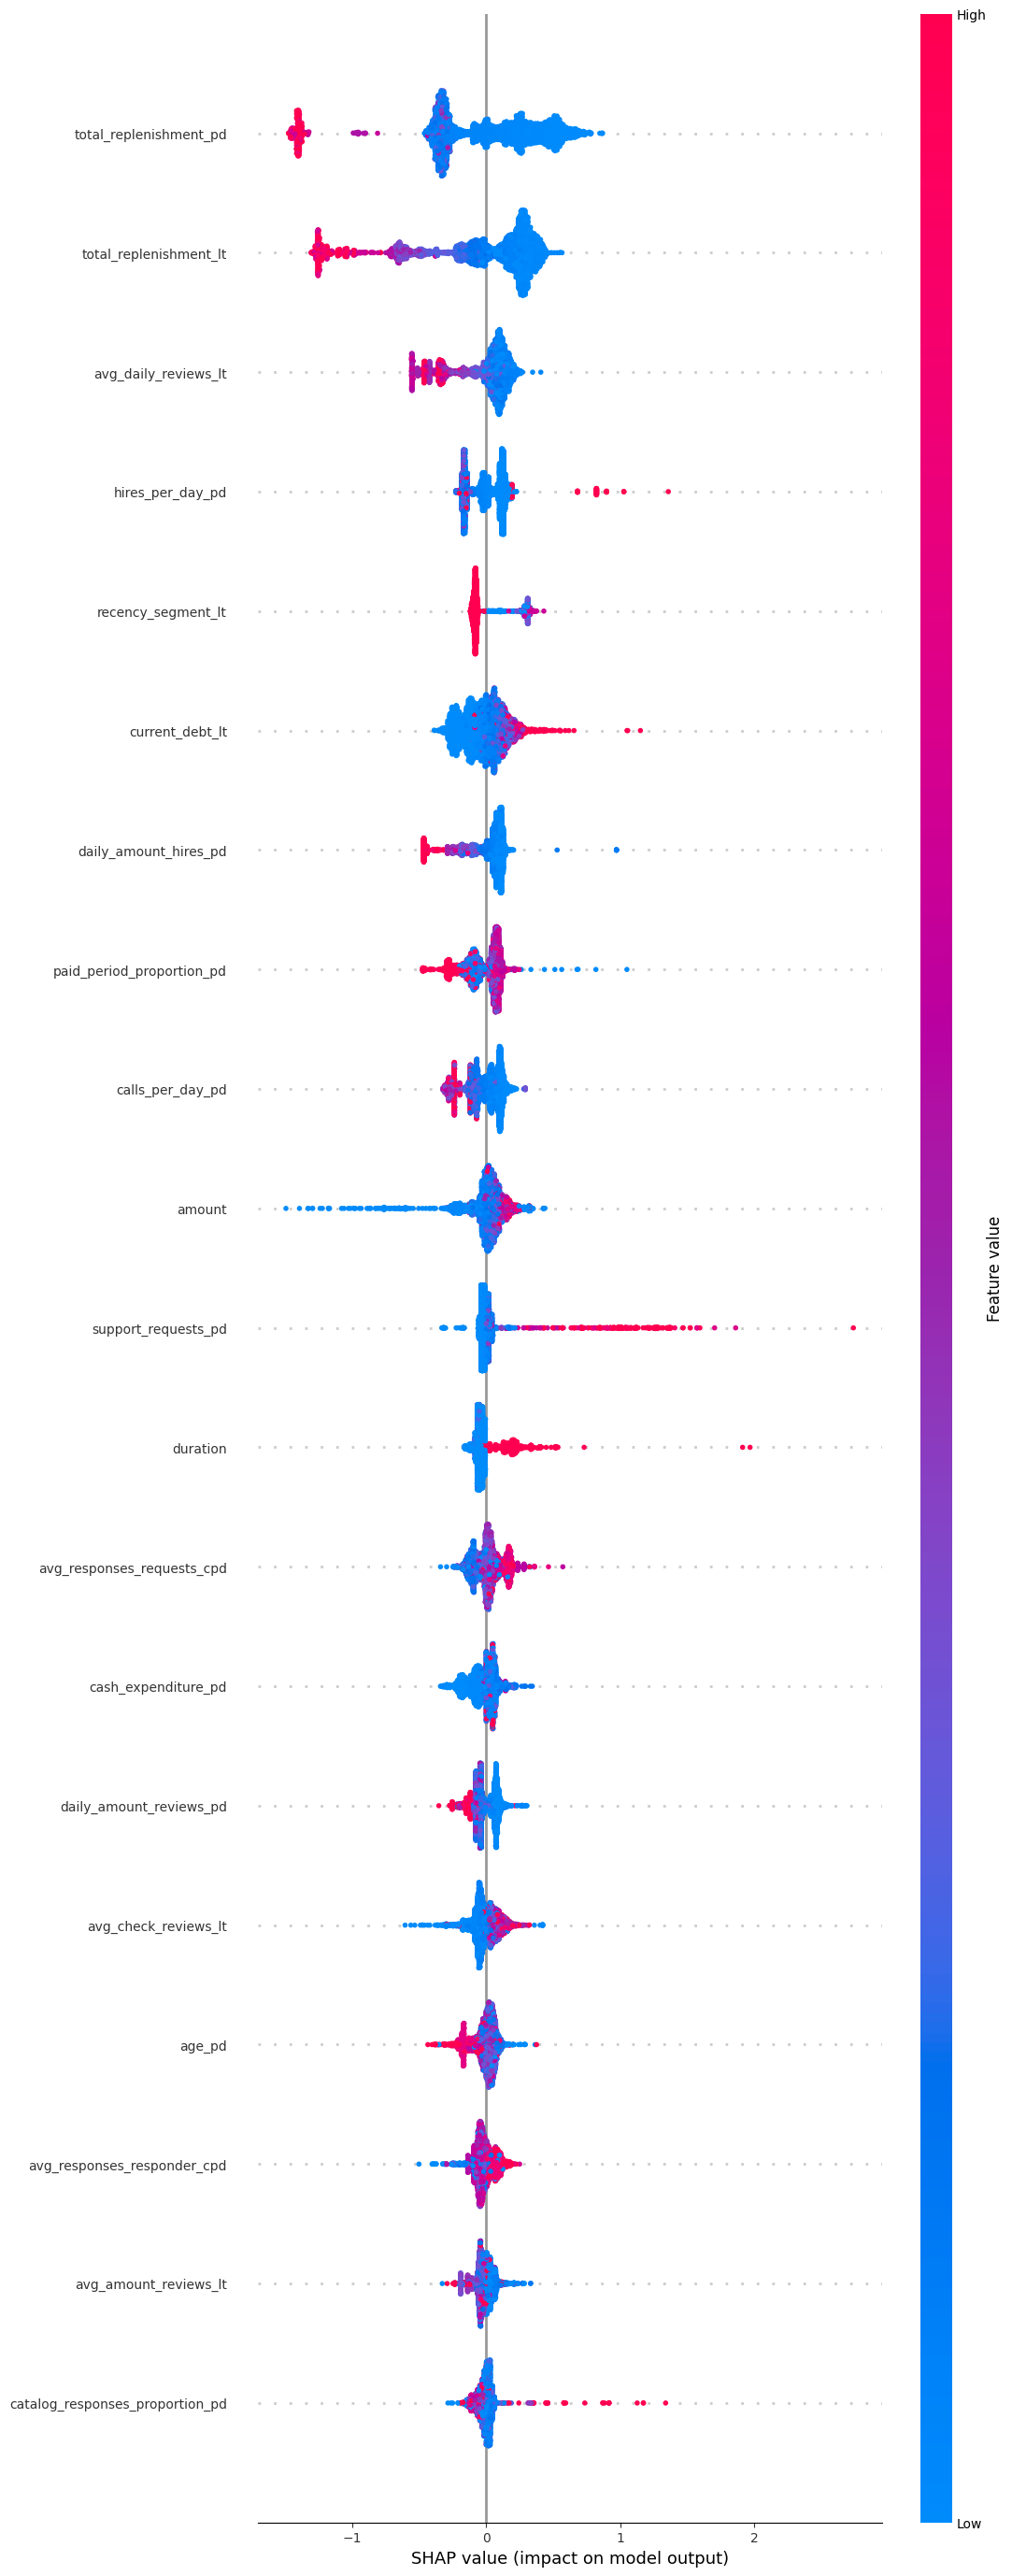

In [71]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_size=(12,8), show=False)
plt.gcf().set_size_inches(12, 30) 

for ax in plt.gcf().axes:
    for label in ax.get_yticklabels() + ax.get_xticklabels():
        label.set_fontsize(10) 
    for line in ax.get_lines():
        line.set_linewidth(2)
    for artist in ax.get_children():
        if isinstance(artist, plt.Text):
            artist.set_size(10)

Описательная статистика для total_replenishment_pd:
count   21996.0000
mean    17005.3191
std     19739.9606
min         0.0000
25%      2500.0000
50%      8000.0000
75%     24497.2500
max     57493.1250
Name: total_replenishment_pd, dtype: float64

Описательная статистика для total_replenishment_lt:
count    21996.0000
mean     81844.3631
std      96998.5489
min          0.0000
25%      11040.0000
50%      33875.0000
75%     120397.5000
max     284433.7500
Name: total_replenishment_lt, dtype: float64

Описательная статистика для avg_daily_reviews_lt:
count   21996.0000
mean        0.0624
std         0.0627
min         0.0000
25%         0.0140
50%         0.0364
75%         0.0930
max         0.2114
Name: avg_daily_reviews_lt, dtype: float64

Описательная статистика для amount:
count   21996.0000
mean     1954.1326
std      1660.6979
min        50.0000
25%       750.0000
50%      1250.0000
75%      2730.0000
max      5700.0000
Name: amount, dtype: float64

Описательная статистика для 

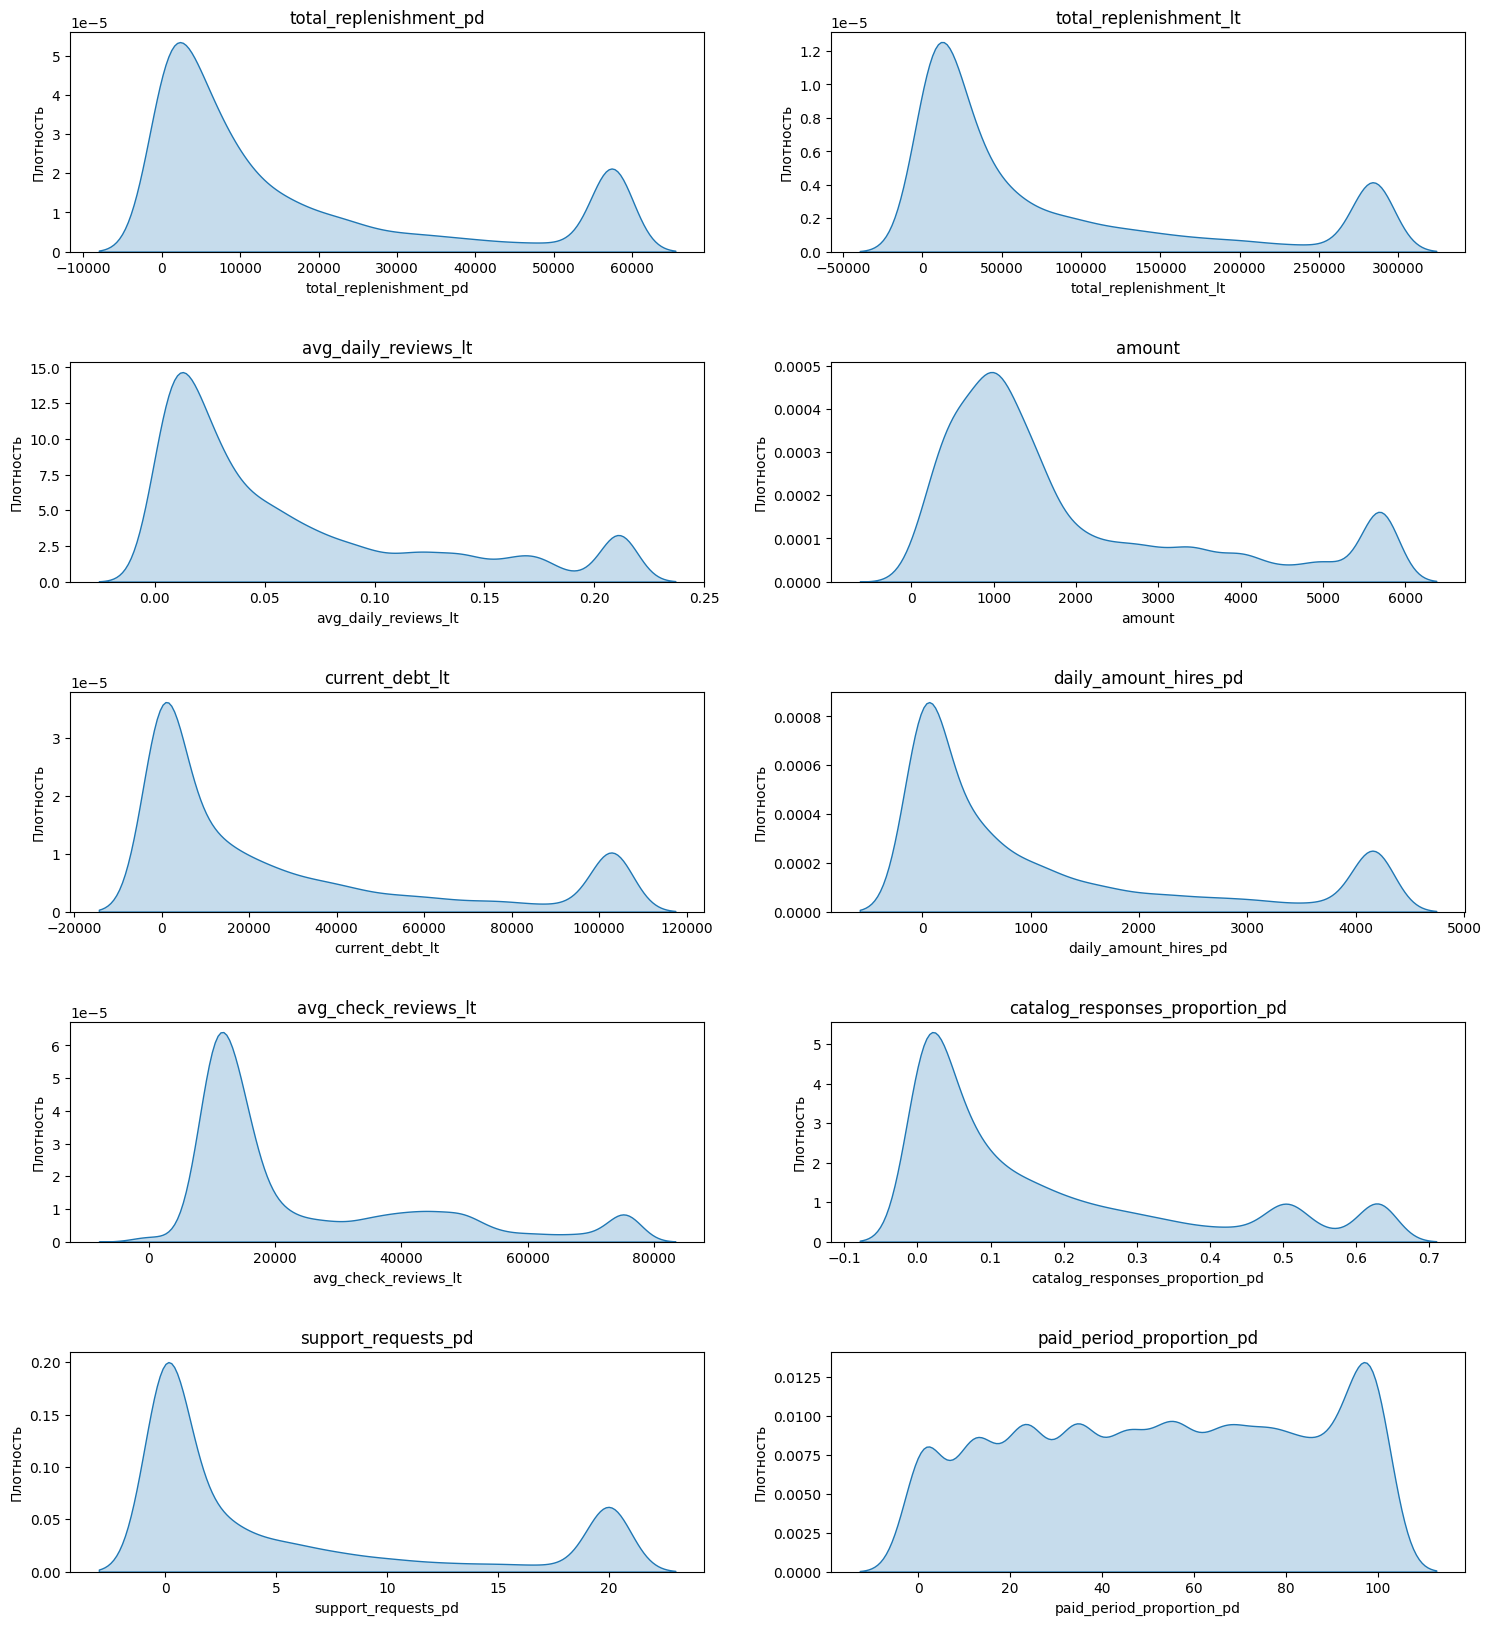

In [78]:
top_10_features = pd.Series(model.feature_importances_, index=X_train_cleaned.columns).nlargest(10).index

for feature in top_10_features:
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    data[feature] = data[feature].clip(lower=lower_bound, upper=upper_bound)

# Выводим отдельные графики для каждой из топ 10 переменных
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 20), dpi=100)
axes = axes.ravel()

for i, feature in enumerate(top_10_features):
    sns.kdeplot(data[feature], ax=axes[i], shade=True)
    axes[i].set_title(feature)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Плотность')
    
    print(f"Описательная статистика для {feature}:")
    print(data[feature].describe())
    print()

plt.subplots_adjust(hspace=0.5)
plt.show()

Топ 10 категориальных переменных по коэффициенту взаимной информации:
['work_start_date', 'phone_number', 'selected_service_categories_lt', 'data_collection_date', 'installment_status', 'season', 'base_city_pd', 'os_lt', 'gender_lt', 'season_opened']

Распределение категориальных переменных:


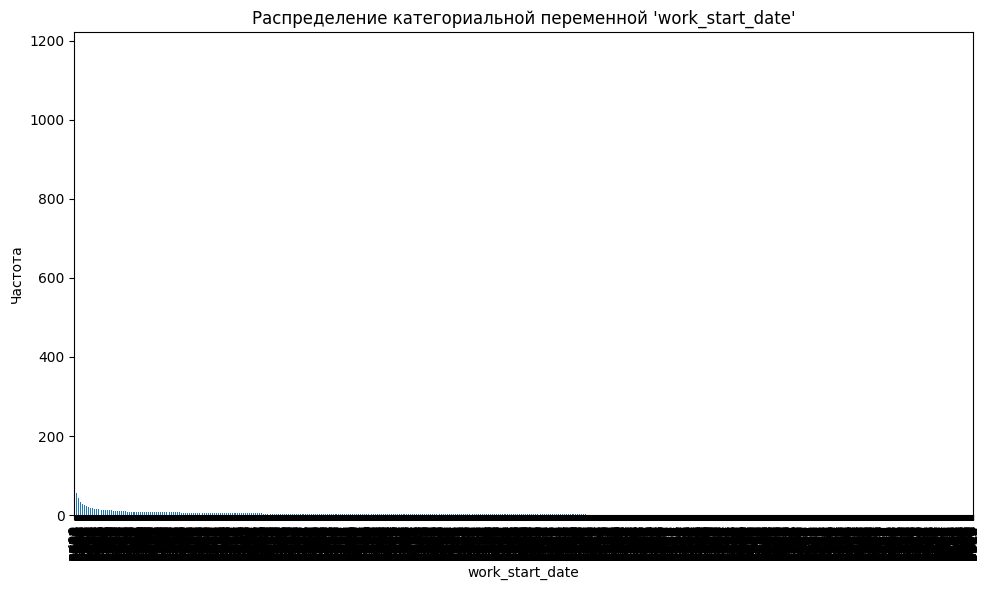

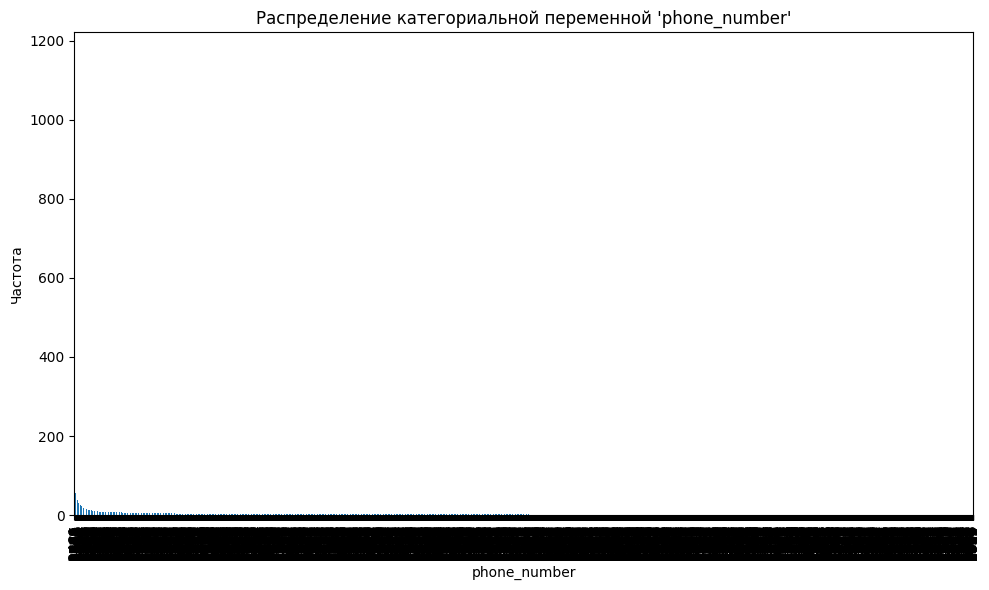

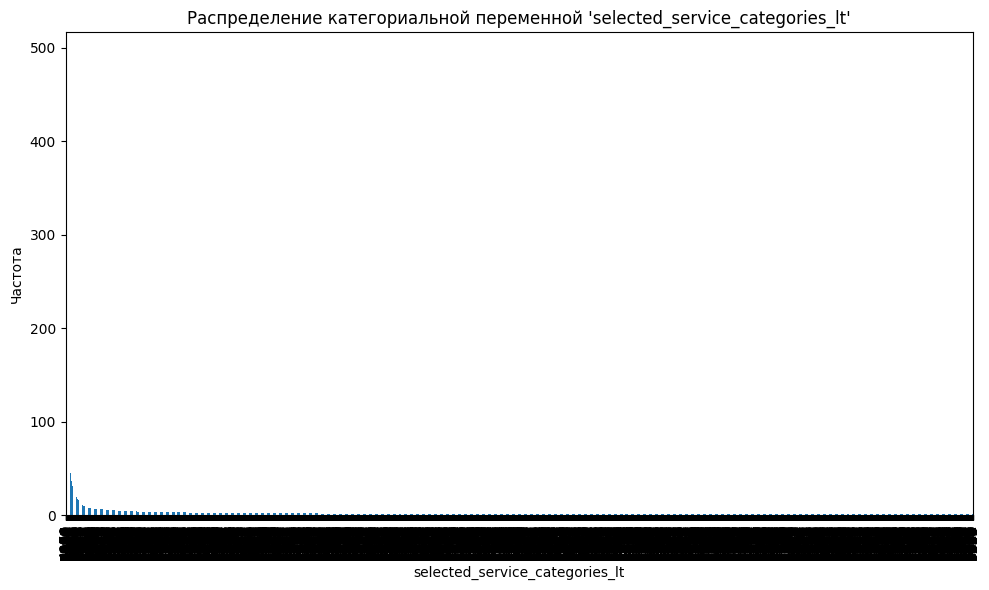

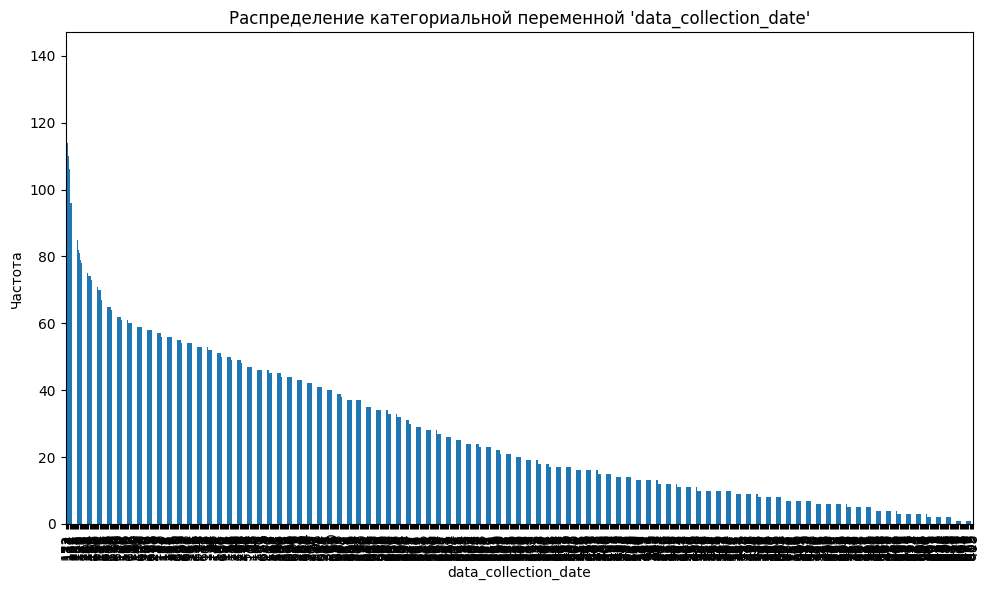

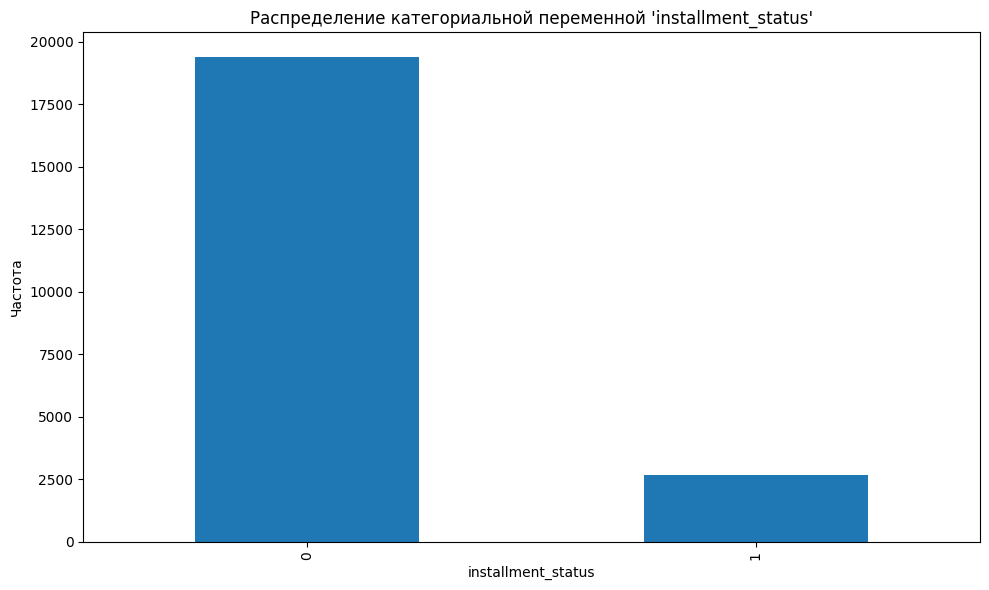

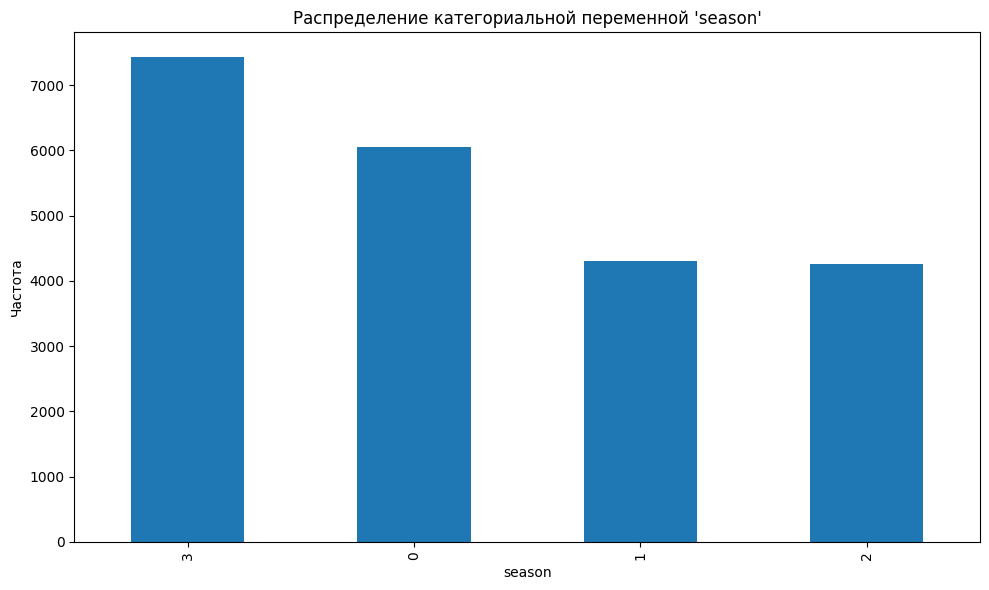

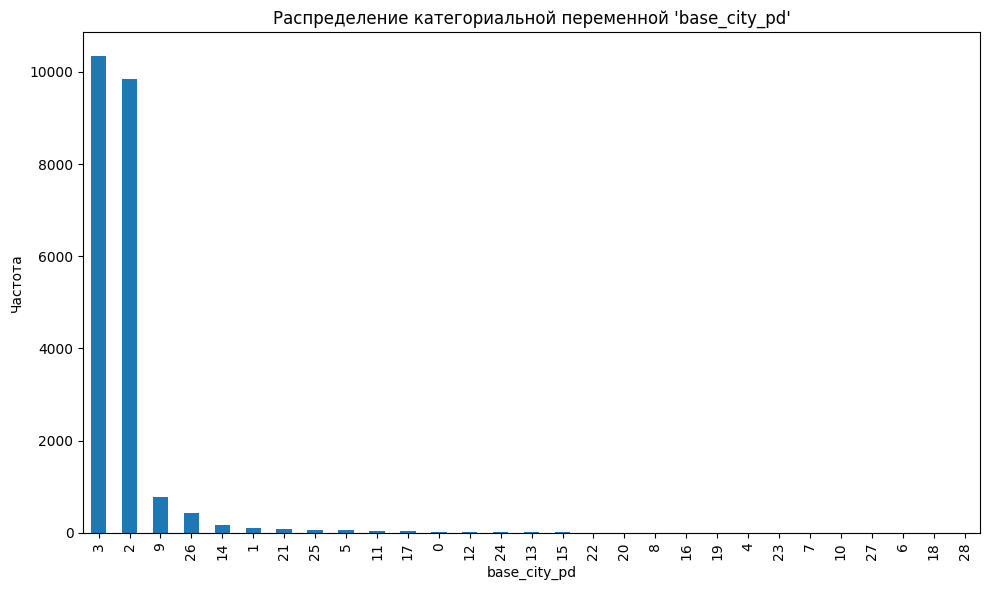

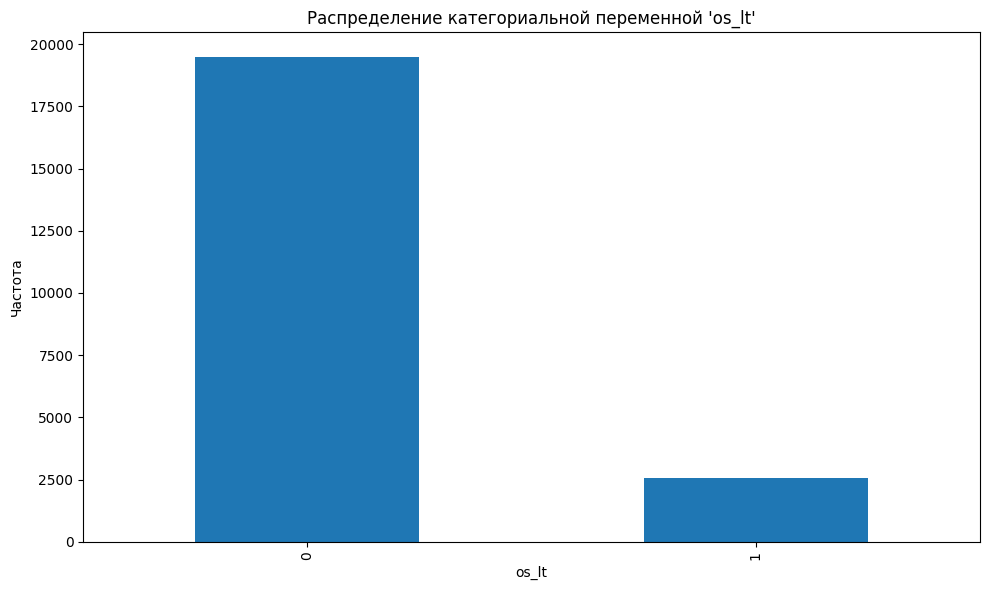

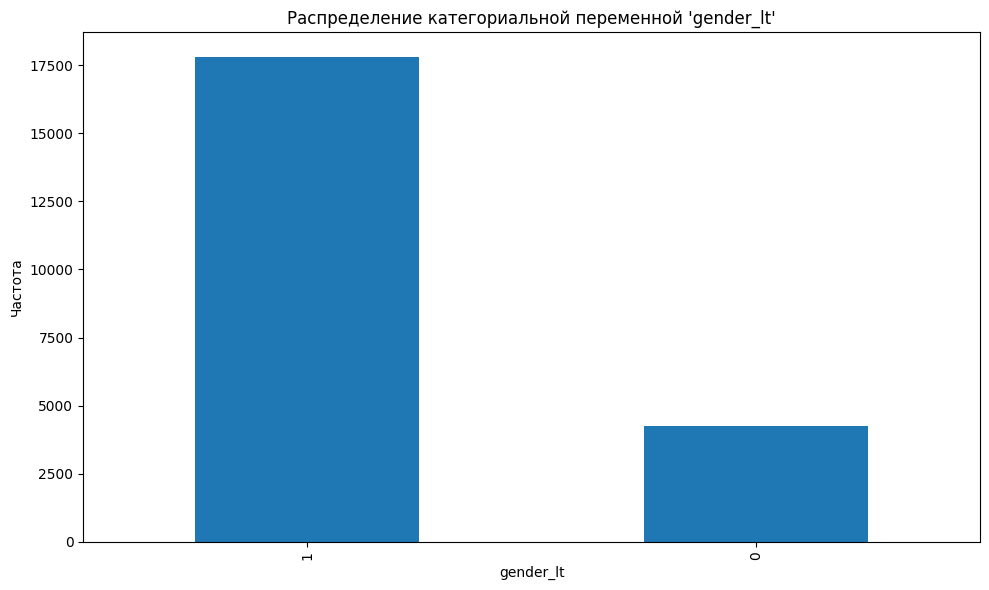

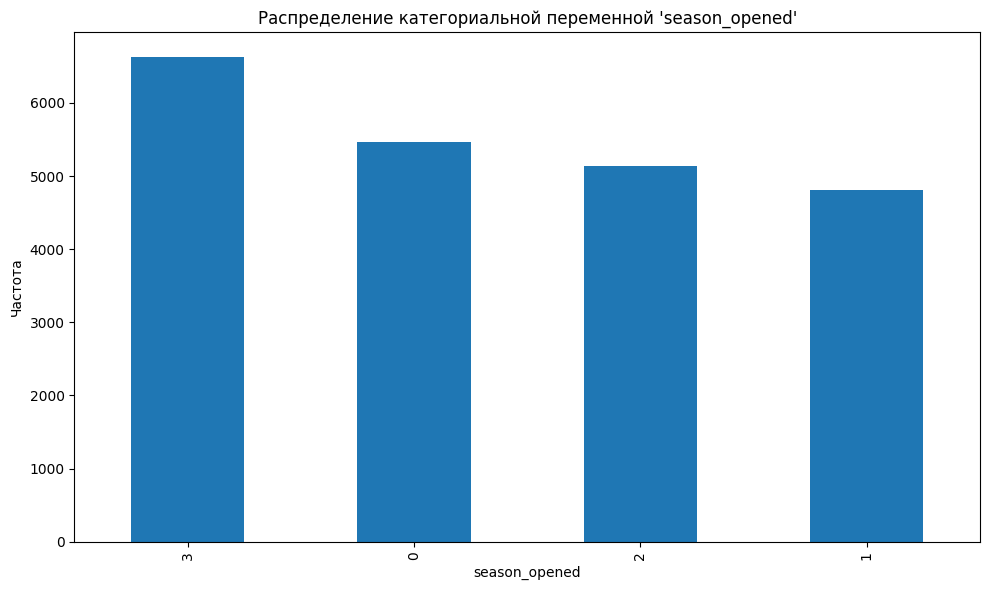

In [82]:
df = pd.read_csv(r'D:\python\1_Internship\naimi_new4_preprocessed.csv', low_memory=False)

cat_cols = df.select_dtypes(exclude=np.number).columns

for col in cat_cols:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

cat_mi_scores = []
for col in cat_cols:
    mi_score = mutual_info_classif(df[[col]], df['target'])[0]
    cat_mi_scores.append(mi_score)

cat_mi_df = pd.DataFrame({'feature': cat_cols, 'mi_score': cat_mi_scores})

top_10_cat = cat_mi_df.sort_values('mi_score', ascending=False).head(10)['feature'].tolist()

print("Топ 10 категориальных переменных по коэффициенту взаимной информации:")
print(top_10_cat)

print("\nРаспределение категориальных переменных:")

for col in top_10_cat:
    plt.figure(figsize=(10, 6))
    df[col].value_counts().plot(kind='bar')
    plt.title(f"Распределение категориальной переменной '{col}'")
    plt.xlabel(col)
    plt.ylabel("Частота")
    plt.tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()
